In [15]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import cv2
from glob import glob
from sklearn.metrics import (
    precision_recall_curve, f1_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
)
from tqdm import tqdm


In [16]:
DATASET_DIR = '/content/drive/MyDrive/wood_dataset/wood'
IMG_SIZE = 256

np.random.seed(42)
tf.random.set_seed(42)


In [17]:
def preprocess_image(image_path, target_size=(IMG_SIZE, IMG_SIZE)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    mask = thresh > 0
    img[~np.stack([mask]*3, axis=2)] = 0
    img = cv2.resize(img, target_size)
    return img.astype(np.float32) / 255.0

def load_dataset(directory, is_defect=False):
    image_paths = sorted(glob(os.path.join(directory, '*.png')) + glob(os.path.join(directory, '*.jpg')))
    images, filenames = [], []
    print(f"Loading {len(image_paths)} images from {directory}...")
    for path in tqdm(image_paths):
        img = preprocess_image(path)
        images.append(img)
        filenames.append(os.path.basename(path))
    return np.array(images), filenames

def load_images_from_folder(folder):
    image_paths = sorted(glob(os.path.join(folder, '*.png')) + glob(os.path.join(folder, '*.jpg')))
    images = []
    print(f"Loading {len(image_paths)} images from {folder}...")
    for path in tqdm(image_paths):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"[WARN] Could not read: {path}")
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = (img.astype(np.float32) / 255.0 > 0.5).astype(np.float32)
        images.append(img)
    return np.array(images)


In [18]:
def build_efficient_ad_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = keras.Input(shape=input_shape)
    base_model = keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False
    x = base_model(inputs)

    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    for filters in [128, 64, 32, 16, 8]:
        x = layers.Conv2DTranspose(filters, 4, strides=2, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(0.2)(x)

    reconstructed = layers.Conv2D(3, 3, padding='same', activation='sigmoid')(x)
    anomaly_mask = layers.Conv2D(1, 1, activation='sigmoid')(x)

    return keras.Model(inputs=inputs, outputs=[reconstructed, anomaly_mask])


In [20]:
def calculate_anomaly_scores(model, images):
    reconstructed, predicted_masks = model.predict(images)
    reconstruction_errors = np.mean(np.square(images - reconstructed), axis=(1, 2, 3))
    mask_scores = np.mean(predicted_masks, axis=(1, 2, 3))
    return 0.7 * reconstruction_errors + 0.3 * mask_scores, predicted_masks

def find_optimal_threshold(y_true, anomaly_scores):
    precisions, recalls, thresholds = precision_recall_curve(y_true, anomaly_scores)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    f1_scores = np.nan_to_num(f1_scores)
    best_idx = np.argmax(f1_scores)
    return thresholds[best_idx], f1_scores[best_idx]

def calculate_segmentation_metrics(y_true_list, y_pred_list, threshold=0.5):
    ious, dices, precisions, recalls = [], [], [], []
    for y_true, y_pred in zip(y_true_list, y_pred_list):
        y_true_bin = (y_true >= 0.5).astype(np.uint8)
        y_pred_bin = (y_pred >= threshold).astype(np.uint8)
        intersection = np.logical_and(y_true_bin, y_pred_bin)
        union = np.logical_or(y_true_bin, y_pred_bin)
        tp = np.sum(intersection)
        fp = np.sum(y_pred_bin) - tp
        fn = np.sum(y_true_bin) - tp

        ious.append(tp / (np.sum(union) + 1e-10))
        dices.append(2 * tp / (np.sum(y_true_bin) + np.sum(y_pred_bin) + 1e-10))
        precisions.append(tp / (tp + fp + 1e-10))
        recalls.append(tp / (tp + fn + 1e-10))

    return {
        "mean_iou": np.mean(ious),
        "mean_dice": np.mean(dices),
        "mean_precision": np.mean(precisions),
        "mean_recall": np.mean(recalls)
    }


In [21]:
def visualize_results(images, scores, pred_masks, true_masks, threshold, num_samples=5):
    indices = np.random.choice(len(images), min(num_samples, len(images)), replace=False)
    for i, idx in enumerate(indices):
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))
        axes[0].imshow(images[idx])
        axes[0].set_title(f"Original\nScore: {scores[idx]:.4f}")
        axes[0].axis('off')

        axes[1].imshow(pred_masks[idx, :, :, 0], cmap='jet')
        axes[1].set_title("Predicted Mask")
        axes[1].axis('off')

        axes[2].imshow(pred_masks[idx, :, :, 0] >= 0.5, cmap='gray')
        axes[2].set_title("Thresholded Mask")
        axes[2].axis('off')

        axes[3].imshow(true_masks[idx], cmap='gray')
        axes[3].set_title("Ground Truth")
        axes[3].axis('off')

        plt.tight_layout()
        plt.show()


In [22]:
def main():
    train_images, _ = load_dataset(os.path.join(DATASET_DIR, 'train/good'))
    test_good, _ = load_dataset(os.path.join(DATASET_DIR, 'test/good'))
    test_defect, _ = load_dataset(os.path.join(DATASET_DIR, 'test/defect'))
    mask_defect = load_images_from_folder(os.path.join(DATASET_DIR, 'ground_truth/defect'))

    model = build_efficient_ad_model()
    model.compile(optimizer=keras.optimizers.Adam(0.001),
                  loss=['mse', 'binary_crossentropy'],
                  loss_weights=[0.5, 0.5])
    model.summary()

    checkpoint = keras.callbacks.ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True, verbose=1)

    history = model.fit(
        train_images,
        [train_images, np.zeros((len(train_images), IMG_SIZE, IMG_SIZE, 1))],
        epochs=30, batch_size=16, validation_split=0.1,
        callbacks=[checkpoint]
    )

    # LOSS GRAFİĞİ
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    model = keras.models.load_model("best_model.h5", compile=False)
    model.compile(optimizer=keras.optimizers.Adam(0.001),
                  loss=['mse', 'binary_crossentropy'],
                  loss_weights=[0.5, 0.5])

    test_good_scores, _ = calculate_anomaly_scores(model, test_good)
    test_defect_scores, predicted_masks = calculate_anomaly_scores(model, test_defect)

    all_scores = np.concatenate([test_good_scores, test_defect_scores])
    all_labels = np.concatenate([np.zeros(len(test_good_scores)), np.ones(len(test_defect_scores))])

    threshold, best_f1 = find_optimal_threshold(all_labels, all_scores)
    print(f"\n🔎 Optimal Threshold: {threshold:.4f} | Best F1: {best_f1:.4f}")

    y_pred = (all_scores >= threshold).astype(int)
    precision = precision_score(all_labels, y_pred)
    recall = recall_score(all_labels, y_pred)
    f1 = f1_score(all_labels, y_pred)
    roc_auc = roc_auc_score(all_labels, all_scores)

    print(f"\n📊 Classification:")
    print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | ROC AUC: {roc_auc:.4f}")

    # ROC CURVE
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # CONFUSION MATRIX
    cm = confusion_matrix(all_labels, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Good", "Defect"])
    disp.plot(cmap="Blues", values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

    # SEGMENTASYON METRİKLERİ
    seg_metrics = calculate_segmentation_metrics(mask_defect, predicted_masks[..., 0])
    print("\n📐 Segmentation Metrics:")
    for key, value in seg_metrics.items():
        print(f"{key.replace('_', ' ').title()}: {value:.4f}")

    visualize_results(test_defect, test_defect_scores, predicted_masks, mask_defect, threshold)


Loading 70 images from /content/drive/MyDrive/wood_dataset/wood/train/good...


100%|██████████| 70/70 [00:04<00:00, 14.03it/s]


Loading 70 images from /content/drive/MyDrive/wood_dataset/wood/test/good...


100%|██████████| 70/70 [00:03<00:00, 22.72it/s]


Loading 71 images from /content/drive/MyDrive/wood_dataset/wood/test/defect...


100%|██████████| 71/71 [00:02<00:00, 32.03it/s]


Loading 71 images from /content/drive/MyDrive/wood_dataset/wood/ground_truth/defect...


100%|██████████| 71/71 [00:00<00:00, 111.97it/s]
<ipython-input-18-858a05805c74>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_224      │ (None, 8, 8, 1280)     │      2,257,984 │ input_layer_6[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 8, 8, 128)      │      1,474,688 │ mobilenetv2_1.00_224[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 8, 8, 128)      │            512 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_18            │ (None, 8, 8, 128)      │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_15       │ (None, 16, 16, 128)    │        262,272 │ leaky_re_lu_18[0][0]   │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 16, 16, 128)    │            512 │ conv2d_transpose_15[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_19            │ (None, 16, 16, 128)    │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_16       │ (None, 32, 32, 64)     │        131,136 │ leaky_re_lu_19[0][0]   │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 32, 32, 64)     │            256 │ conv2d_transpose_16[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_20            │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_17       │ (None, 64, 64, 32)     │         32,800 │ leaky_re_lu_20[0][0]   │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 64, 64, 32)     │            128 │ conv2d_transpose_17[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_21       

 Total params: 4,170,876 (15.91 MB)

 Trainable params: 1,912,140 (7.29 MB)

 Non-trainable params: 2,258,736 (8.62 MB)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - conv2d_10_loss: 0.1095 - conv2d_11_loss: 0.5484 - loss: 0.3290  
Epoch 1: val_loss improved from inf to 0.37532, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - conv2d_10_loss: 0.1089 - conv2d_11_loss: 0.5449 - loss: 0.3270 - val_conv2d_10_loss: 0.0707 - val_conv2d_11_loss: 0.6800 - val_loss: 0.3753
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - conv2d_10_loss: 0.0976 - conv2d_11_loss: 0.4762 - loss: 0.2869
Epoch 2: val_loss improved from 0.37532 to 0.36567, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - conv2d_10_loss: 0.0972 - conv2d_11_loss: 0.4746 - loss: 0.2860 - val_conv2d_10_loss: 0.0709 - val_conv2d_11_loss: 0.6604 - val_loss: 0.3657
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - conv2d_10_loss: 0.0881 - conv2d_11_loss: 0.4378 - loss: 0.2630
Epoch 3: val_loss improved from 0.36567 to 0.35490, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - conv2d_10_loss: 0.0878 - conv2d_11_loss: 0.4366 - loss: 0.2622 - val_conv2d_10_loss: 0.0704 - val_conv2d_11_loss: 0.6394 - val_loss: 0.3549
Epoch 4/30
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - conv2d_10_loss: 0.0806 - conv2d_11_loss: 0.4114 - loss: 0.2460 
Epoch 4: val_loss improved from 0.35490 to 0.34416, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - conv2d_10_loss: 0.0799 - conv2d_11_loss: 0.4091 - loss: 0.2445 - val_conv2d_10_loss: 0.0691 - val_conv2d_11_loss: 0.6193 - val_loss: 0.3442
Epoch 5/30
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - conv2d_10_loss: 0.0741 - conv2d_11_loss: 0.3900 - loss: 0.2321
Epoch 5: val_loss improved from 0.34416 to 0.33344, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - conv2d_10_loss: 0.0737 - conv2d_11_loss: 0.3881 - loss: 0.2309 - val_conv2d_10_loss: 0.0673 - val_conv2d_11_loss: 0.5996 - val_loss: 0.3334
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - conv2d_10_loss: 0.0692 - conv2d_11_loss: 0.3710 - loss: 0.2201
Epoch 6: val_loss improved from 0.33344 to 0.32476, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - conv2d_10_loss: 0.0691 - conv2d_11_loss: 0.3704 - loss: 0.2198 - val_conv2d_10_loss: 0.0652 - val_conv2d_11_loss: 0.5843 - val_loss: 0.3248
Epoch 7/30
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - conv2d_10_loss: 0.0660 - conv2d_11_loss: 0.3562 - loss: 0.2111
Epoch 7: val_loss improved from 0.32476 to 0.31718, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - conv2d_10_loss: 0.0659 - conv2d_11_loss: 0.3547 - loss: 0.2103 - val_conv2d_10_loss: 0.0634 - val_conv2d_11_loss: 0.5709 - val_loss: 0.3172
Epoch 8/30
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - conv2d_10_loss: 0.0636 - conv2d_11_loss: 0.3421 - loss: 0.2029
Epoch 8: val_loss improved from 0.31718 to 0.31102, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - conv2d_10_loss: 0.0636 - conv2d_11_loss: 0.3408 - loss: 0.2022 - val_conv2d_10_loss: 0.0619 - val_conv2d_11_loss: 0.5602 - val_loss: 0.3110
Epoch 9/30
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - conv2d_10_loss: 0.0619 - conv2d_11_loss: 0.3298 - loss: 0.1959
Epoch 9: val_loss improved from 0.31102 to 0.30591, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - conv2d_10_loss: 0.0619 - conv2d_11_loss: 0.3287 - loss: 0.1953 - val_conv2d_10_loss: 0.0605 - val_conv2d_11_loss: 0.5513 - val_loss: 0.3059
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - conv2d_10_loss: 0.0605 - conv2d_11_loss: 0.3180 - loss: 0.1892
Epoch 10: val_loss improved from 0.30591 to 0.30096, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - conv2d_10_loss: 0.0605 - conv2d_11_loss: 0.3176 - loss: 0.1890 - val_conv2d_10_loss: 0.0595 - val_conv2d_11_loss: 0.5424 - val_loss: 0.3010
Epoch 11/30
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - conv2d_10_loss: 0.0594 - conv2d_11_loss: 0.3082 - loss: 0.1838
Epoch 11: val_loss improved from 0.30096 to 0.29662, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - conv2d_10_loss: 0.0594 - conv2d_11_loss: 0.3072 - loss: 0.1833 - val_conv2d_10_loss: 0.0587 - val_conv2d_11_loss: 0.5345 - val_loss: 0.2966
Epoch 12/30
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - conv2d_10_loss: 0.0584 - conv2d_11_loss: 0.2985 - loss: 0.1784
Epoch 12: val_loss improved from 0.29662 to 0.29189, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - conv2d_10_loss: 0.0584 - conv2d_11_loss: 0.2976 - loss: 0.1780 - val_conv2d_10_loss: 0.0581 - val_conv2d_11_loss: 0.5257 - val_loss: 0.2919
Epoch 13/30
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - conv2d_10_loss: 0.0573 - conv2d_11_loss: 0.2896 - loss: 0.1735
Epoch 13: val_loss improved from 0.29189 to 0.28740, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - conv2d_10_loss: 0.0574 - conv2d_11_loss: 0.2888 - loss: 0.1731 - val_conv2d_10_loss: 0.0574 - val_conv2d_11_loss: 0.5174 - val_loss: 0.2874
Epoch 14/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - conv2d_10_loss: 0.0562 - conv2d_11_loss: 0.2809 - loss: 0.1686
Epoch 14: val_loss improved from 0.28740 to 0.28318, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - conv2d_10_loss: 0.0562 - conv2d_11_loss: 0.2807 - loss: 0.1684 - val_conv2d_10_loss: 0.0568 - val_conv2d_11_loss: 0.5095 - val_loss: 0.2832
Epoch 15/30
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - conv2d_10_loss: 0.0548 - conv2d_11_loss: 0.2738 - loss: 0.1643 
Epoch 15: val_loss improved from 0.28318 to 0.27865, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - conv2d_10_loss: 0.0549 - conv2d_11_loss: 0.2730 - loss: 0.1640 - val_conv2d_10_loss: 0.0562 - val_conv2d_11_loss: 0.5011 - val_loss: 0.2787
Epoch 16/30
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - conv2d_10_loss: 0.0533 - conv2d_11_loss: 0.2667 - loss: 0.1600 
Epoch 16: val_loss improved from 0.27865 to 0.27430, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - conv2d_10_loss: 0.0533 - conv2d_11_loss: 0.2660 - loss: 0.1597 - val_conv2d_10_loss: 0.0555 - val_conv2d_11_loss: 0.4931 - val_loss: 0.2743
Epoch 17/30
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - conv2d_10_loss: 0.0512 - conv2d_11_loss: 0.2602 - loss: 0.1557
Epoch 17: val_loss improved from 0.27430 to 0.26959, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - conv2d_10_loss: 0.0512 - conv2d_11_loss: 0.2596 - loss: 0.1554 - val_conv2d_10_loss: 0.0545 - val_conv2d_11_loss: 0.4846 - val_loss: 0.2696
Epoch 18/30
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - conv2d_10_loss: 0.0487 - conv2d_11_loss: 0.2543 - loss: 0.1515
Epoch 18: val_loss improved from 0.26959 to 0.26481, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - conv2d_10_loss: 0.0486 - conv2d_11_loss: 0.2537 - loss: 0.1512 - val_conv2d_10_loss: 0.0535 - val_conv2d_11_loss: 0.4761 - val_loss: 0.2648
Epoch 19/30
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - conv2d_10_loss: 0.0459 - conv2d_11_loss: 0.2487 - loss: 0.1473
Epoch 19: val_loss improved from 0.26481 to 0.25972, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - conv2d_10_loss: 0.0459 - conv2d_11_loss: 0.2481 - loss: 0.1470 - val_conv2d_10_loss: 0.0522 - val_conv2d_11_loss: 0.4672 - val_loss: 0.2597
Epoch 20/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - conv2d_10_loss: 0.0429 - conv2d_11_loss: 0.2428 - loss: 0.1429
Epoch 20: val_loss improved from 0.25972 to 0.25437, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - conv2d_10_loss: 0.0429 - conv2d_11_loss: 0.2426 - loss: 0.1427 - val_conv2d_10_loss: 0.0506 - val_conv2d_11_loss: 0.4582 - val_loss: 0.2544
Epoch 21/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - conv2d_10_loss: 0.0394 - conv2d_11_loss: 0.2376 - loss: 0.1385
Epoch 21: val_loss improved from 0.25437 to 0.24836, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - conv2d_10_loss: 0.0394 - conv2d_11_loss: 0.2374 - loss: 0.1384 - val_conv2d_10_loss: 0.0487 - val_conv2d_11_loss: 0.4481 - val_loss: 0.2484
Epoch 22/30
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - conv2d_10_loss: 0.0359 - conv2d_11_loss: 0.2327 - loss: 0.1343
Epoch 22: val_loss improved from 0.24836 to 0.24204, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - conv2d_10_loss: 0.0357 - conv2d_11_loss: 0.2322 - loss: 0.1340 - val_conv2d_10_loss: 0.0468 - val_conv2d_11_loss: 0.4373 - val_loss: 0.2420
Epoch 23/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - conv2d_10_loss: 0.0323 - conv2d_11_loss: 0.2271 - loss: 0.1297
Epoch 23: val_loss improved from 0.24204 to 0.23559, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step - conv2d_10_loss: 0.0323 - conv2d_11_loss: 0.2269 - loss: 0.1296 - val_conv2d_10_loss: 0.0448 - val_conv2d_11_loss: 0.4264 - val_loss: 0.2356
Epoch 24/30
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - conv2d_10_loss: 0.0289 - conv2d_11_loss: 0.2222 - loss: 0.1256
Epoch 24: val_loss improved from 0.23559 to 0.22904, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - conv2d_10_loss: 0.0288 - conv2d_11_loss: 0.2217 - loss: 0.1253 - val_conv2d_10_loss: 0.0426 - val_conv2d_11_loss: 0.4155 - val_loss: 0.2290
Epoch 25/30
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - conv2d_10_loss: 0.0255 - conv2d_11_loss: 0.2171 - loss: 0.1213
Epoch 25: val_loss improved from 0.22904 to 0.22252, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - conv2d_10_loss: 0.0254 - conv2d_11_loss: 0.2166 - loss: 0.1210 - val_conv2d_10_loss: 0.0405 - val_conv2d_11_loss: 0.4045 - val_loss: 0.2225
Epoch 26/30
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - conv2d_10_loss: 0.0224 - conv2d_11_loss: 0.2117 - loss: 0.1171
Epoch 26: val_loss improved from 0.22252 to 0.21628, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - conv2d_10_loss: 0.0223 - conv2d_11_loss: 0.2112 - loss: 0.1168 - val_conv2d_10_loss: 0.0388 - val_conv2d_11_loss: 0.3938 - val_loss: 0.2163
Epoch 27/30
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - conv2d_10_loss: 0.0199 - conv2d_11_loss: 0.2063 - loss: 0.1131
Epoch 27: val_loss improved from 0.21628 to 0.21010, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - conv2d_10_loss: 0.0198 - conv2d_11_loss: 0.2058 - loss: 0.1128 - val_conv2d_10_loss: 0.0370 - val_conv2d_11_loss: 0.3832 - val_loss: 0.2101
Epoch 28/30
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - conv2d_10_loss: 0.0178 - conv2d_11_loss: 0.2010 - loss: 0.1094 
Epoch 28: val_loss improved from 0.21010 to 0.20396, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - conv2d_10_loss: 0.0177 - conv2d_11_loss: 0.2005 - loss: 0.1091 - val_conv2d_10_loss: 0.0353 - val_conv2d_11_loss: 0.3726 - val_loss: 0.2040
Epoch 29/30
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - conv2d_10_loss: 0.0161 - conv2d_11_loss: 0.1958 - loss: 0.1060 
Epoch 29: val_loss improved from 0.20396 to 0.19821, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - conv2d_10_loss: 0.0161 - conv2d_11_loss: 0.1953 - loss: 0.1057 - val_conv2d_10_loss: 0.0337 - val_conv2d_11_loss: 0.3627 - val_loss: 0.1982
Epoch 30/30
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - conv2d_10_loss: 0.0149 - conv2d_11_loss: 0.1905 - loss: 0.1027 
Epoch 30: val_loss improved from 0.19821 to 0.19269, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - conv2d_10_loss: 0.0148 - conv2d_11_loss: 0.1901 - loss: 0.1024 - val_conv2d_10_loss: 0.0322 - val_conv2d_11_loss: 0.3532 - val_loss: 0.1927


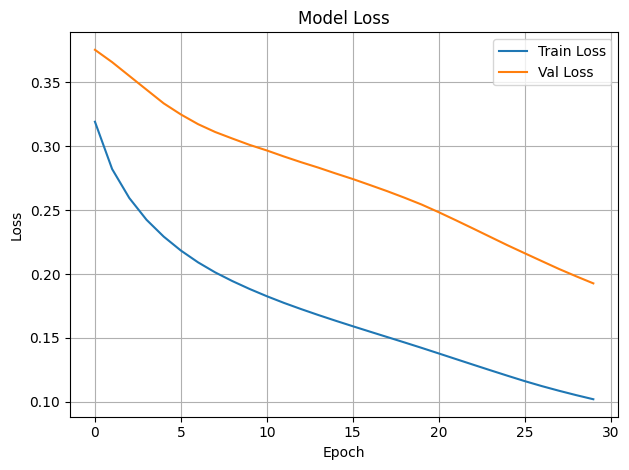

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 937ms/step

🔎 Optimal Threshold: 0.1095 | Best F1: 0.7066

📊 Classification:
Precision: 0.6146 | Recall: 0.8310 | F1: 0.7066 | ROC AUC: 0.6433


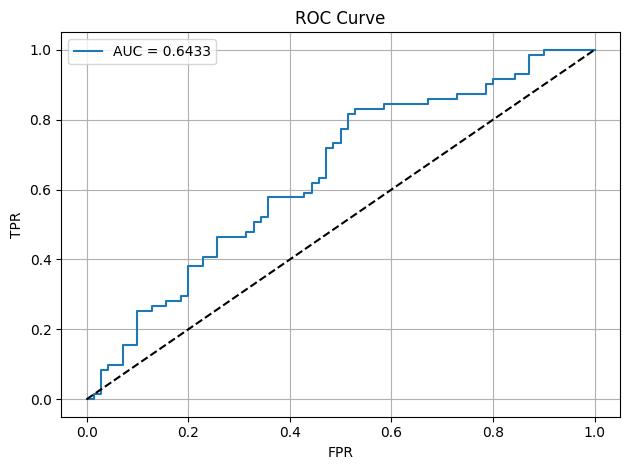

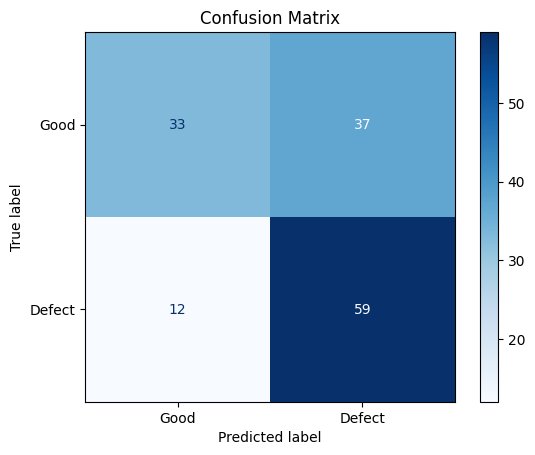


📐 Segmentation Metrics:
Mean Iou: 0.0000
Mean Dice: 0.0000
Mean Precision: 0.0000
Mean Recall: 0.0000


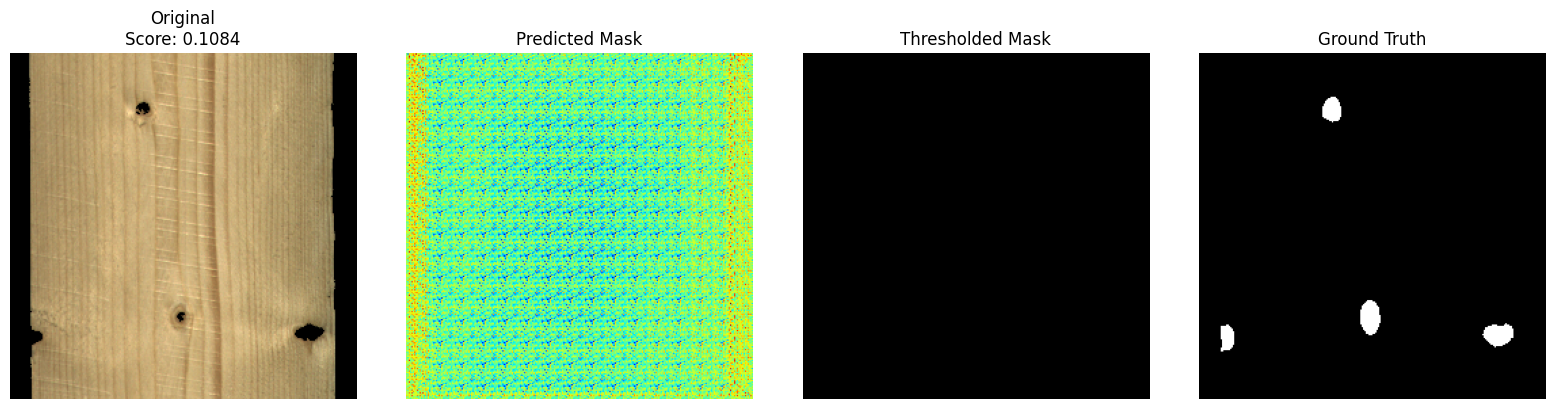

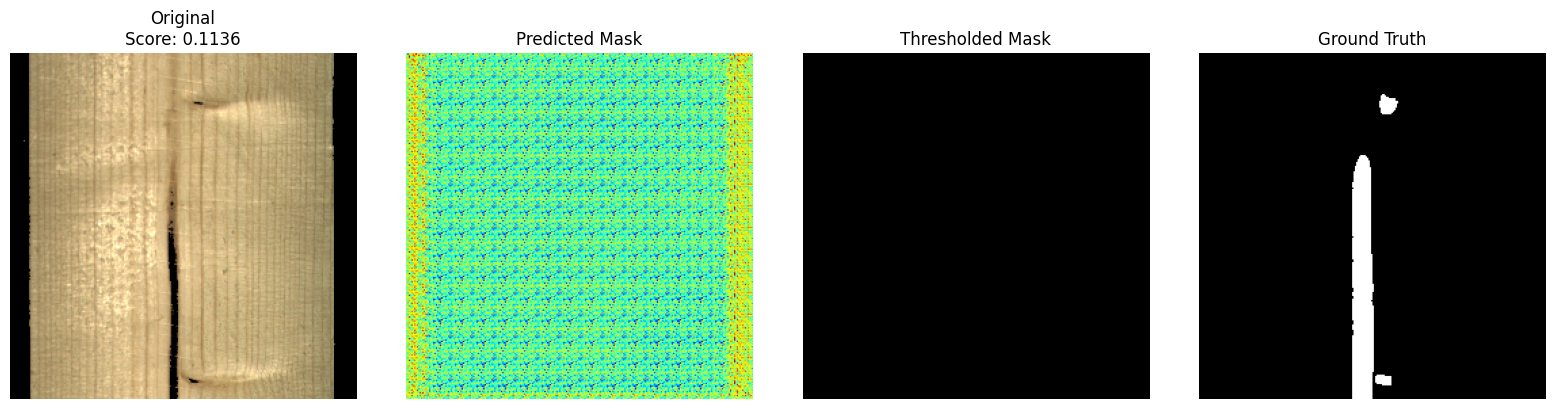

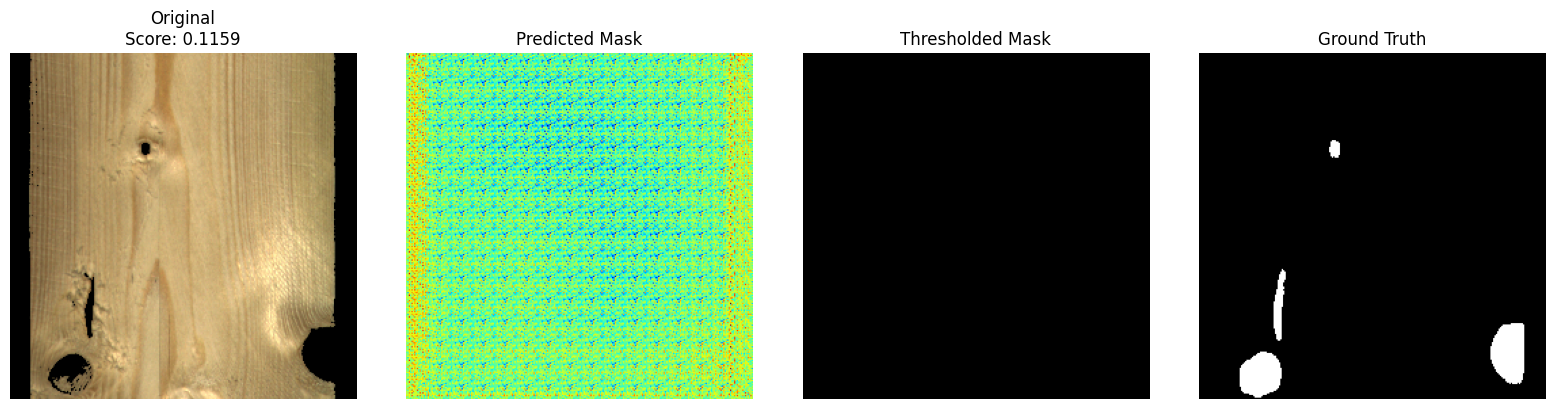

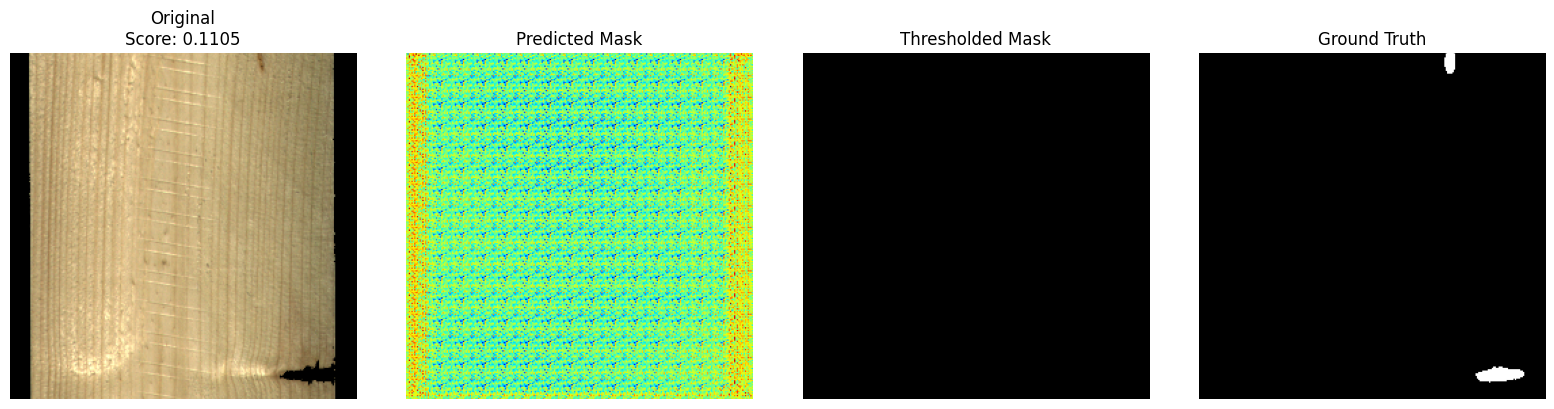

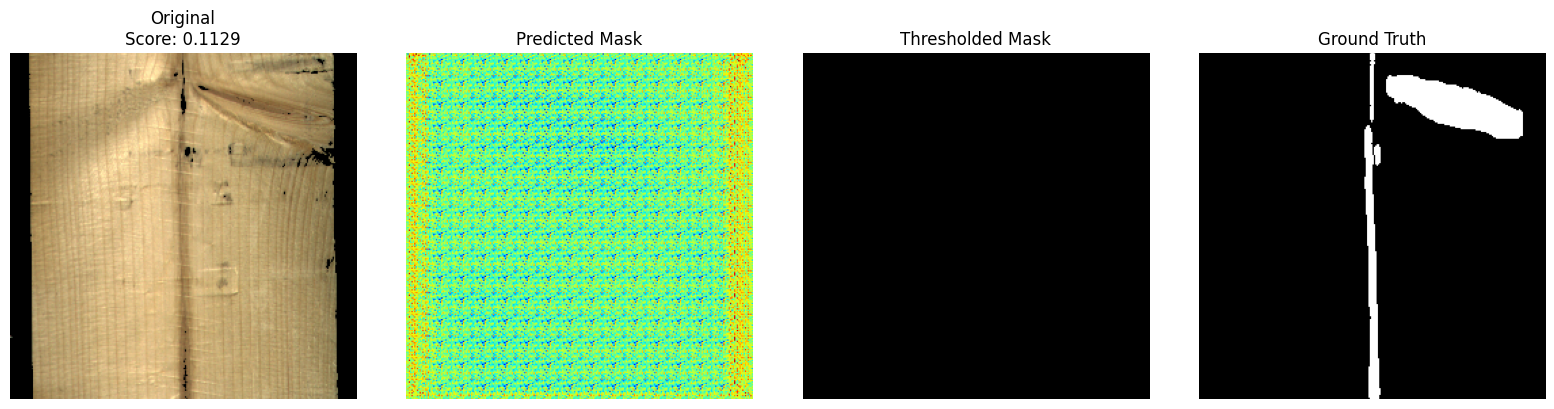

In [23]:
if __name__ == "__main__":
    main()
